# Lane Detection and Tacking - Hough Transform

## 1. Imports and global vars

### 1.1. Import all the necessary libraries

In [1]:
import numpy as np
import math
import cv2
from moviepy.editor import VideoFileClip
from copy import copy as cp

### 1.2. Global variables

In [2]:
# global flags
debug_flag = False
video_display_method = 'html' # options: html, window
write_to_file = False

## 2. Image processing tools & helper functions

### 2.1 Image processing tools

Class *ImgProc* extends the functionality of [tools/image_processing.py](tools/image_processing.py): *BaseImgProc* class

Main functions:
- Edge detection: Canny, Laplace, Sobel X/Y
- Image smoothing: Gaussian Blur
- Convert image color to grayscale
- Probabilistic Hough Line Transform
- Image thresholding
- Normalization
- Dilation

In [3]:
from tools.image_processing import BaseImgProc

class ImgProc(BaseImgProc):

    @classmethod
    def hough_lines_prob(cls, img, rho, theta, threshold, min_line_length, max_line_gap):
        """
        The functions detects lines in the image using the Probabilistic Hough Line Transform.
        NOTE: apply edge detection (e.g. Canny) to the image before using this function
        :param img: the input image
        :param rho: distance resolution of the accumulator in pixels
        :param theta: angle resolution of the accumulator in radians
        :param threshold: the minimum number of intersections points in the Hough space to detect a line
        :param min_line_length: the minimum line length. Line segments shorter than this are rejected.
        :param max_line_gap: the maximum allowed gap between points on the same line to link them.
        """
        return cv2.HoughLinesP(img, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)

    @classmethod
    def detect_edges(cls, img, method='canny', **kwargs):
        """
        Function that organizes the functions for edge detection
        :param img: the input image
        :param method: edge detection method. Options: canny, sobel, laplacian
        :param kwargs: additional keyword arguments
        """
        edges = None
        ksize = kwargs.get('ksize')
        if method == 'canny':
            threshold_1 = kwargs.get('threshold_low')
            threshold_2 = kwargs.get('threshold_high')
            edges = cls.canny(img, threshold_1, threshold_2)
        elif method.startswith('sobel'):
            direction = kwargs.get('direction')
            edges = cls.sobel(img, direction=direction, ksize=ksize)
        elif method == 'laplacian':
            edges = cls.laplacian(img, ksize=ksize)
        
        return edges

### 2.2. Utilities and helper functions

Class *Utils* extend the basic functionality of [tools/utils.py](tools/utils.py): *BaseUtils* class

Main functions:
- plot images
- Intersection point between two 2D lines
- Moving avergage calculation
- Line length and slope

In [4]:
from tools.utils import BaseUtils

class Utils(BaseUtils):

    @classmethod
    def intersect_point(cls, line_a, line_b):
        """
        Calculates the intersection point of two lines given by their endpoints:
        :param line_a: line a represented by (x1, y1, x2, y2), where (x1, y1) and (x2, y2) are endpoints
        :param line_b: line b represented by (x3, y3, x4, y4), where (x3, y3) and (x4, y4) are endpoints

        Returns:
            (x, y): Tuple representing the intersection point, or None if lines are parallel.
        """
        x1, y1, x2, y2 = line_a
        x3, y3, x4, y4 = line_b

        # Calculate the coefficients for the lines
        a1 = y2 - y1
        b1 = x1 - x2
        c1 = a1 * x1 + b1 * y1

        a2 = y4 - y3
        b2 = x3 - x4
        c2 = a2 * x3 + b2 * y3

        # Calculate the determinant
        determinant = a1 * b2 - a2 * b1

        if determinant == 0:
            return None  # Lines are parallel
        
        # Calculate the x and y coordinates
        p_x = (b2 * c1 - b1 * c2) / determinant
        p_y = (a1 * c2 - a2 * c1) / determinant

        return p_x, p_y

    @classmethod
    def moving_avg(cls, avg, new_sample, N=None):
        """
        Calculates the moving average of the line coordinates
        :param avg: current average of the previous N lines coordinates
        :param new_sample: (numpy.ndarray) the new line coordinates to include in the moving average
        :param N: The number of samples over whichh the average is calculated (default: 10)
        Higher N value means smoother average, less sensetive to short term changes
        Lower N value - more responsive average, more sensetive to recent changes 
        Returns:
            numpy.ndarray: The updated moving average of the line coordinates.
            If avg is the array of zeros - means there is no previous average - function will return new_sample.
            Otherwise the function updates the average by removing the influence of oldest sample and adding the influence of the new one.
        """
        N = N if N is not None else 10 
        return new_sample if np.all(avg == 0) else avg - avg / N + new_sample / N

    @classmethod
    def get_line_length(cls, x1, y1, x2, y2):
        """
        Calculates and returns the length of the line with coordinates [x1, y1, x2, y2].
        """
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    @classmethod
    def get_line_slope(cls, x1, y1, x2, y2):
        """
        Calculates and returns the slope of the line with a given coordinates [x1, y1, x2, y2]
        """
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            #slope = float('inf')  # Slope is infinite for vertical lines
            slope = 0
        return slope

# init static flag
Utils.write_to_file = write_to_file

### 2.3. Process video helper functions
The implementation resides in [tools/utils.py](tools/utils.py): *VidProc* class

Main functions:
- display video
- write video to file
- resize video
- get frame from video

In [5]:
from tools.utils import VidProc
VidProc.write_to_file = write_to_file  # init static flag write_to_file

## 3. Pipeline - lane detection and tracking
The <span style='color:#4daafc'>LaneTracker</span> class organaizes the functions used for lane detection and tracking
- <span style='color:#4daafc'>region_of_interest</span> - defines the ROI (region of interest)
- <span style='color:#4daafc'>process_lines</span> - walk threough all lines found by Hough Transform and find the relevant lines
- <span style='color:#4daafc'>draw_lines</span> - draw lines bases on the supplied info - coordinates, color, thickness
- <span style='color:#4daafc'>process_image</span> - runs the pipeline of the lane detection process including:
    1. Convert image to gray scale
    2. Apply noise reduction and smoothing (Gaussian blur)
    3. Edge detetion (e.g. Canny)
    4. Define ROI (region of interest)
    5. Detect lines using Probabilistic Hough Transform
    6. Filter relevant lines and distinguish between left and right lane lines
    7. Draw the lines on top of the input (original) image

In [6]:
class LaneTracker():
    # avg_line - static member, stores average position of the left and right lane lines over multiple video frames/images
    avg_line = None
    # default lane colors
    default_draw_line_params = {'regular': {'color': [255, 255, 0], 'thickness': 4},
                                'representative':  {'color': [255, 0, 0], 'thickness': 8},
                                'reference': {'color': [100, 100, 100], 'thickness': 10},
                                'final': {'color':  [0, 255, 50], 'thickness': 13}}
    # default draw lines debug flags
    default_draw_lines_flags = {k: True if k == 'final' else False for k in default_draw_line_params}

    @classmethod
    def init_params(cls):
        cls.avg_line = {'left': (0, 0, 0, 0), 'right': (0, 0, 0, 0)}

    @classmethod
    def region_of_interest(cls, img, polygon, fill_color=255):
        """
        Polygon area defines the ROI (region of interest), rest of the image is set to black color (0).
        :param img: the input image
        :param polygon: polygon vertices
        :param fill_color: The color to fill the polygon with. Default is 255 (white).
        """
        # initialize the black (0) mask
        mask = np.zeros_like(img)
        # set fill color based on number of channels from image
        color = (fill_color,) * img.shape[2] if len(img.shape) > 2 else fill_color
        # fill the polygon on the mask
        cv2.fillPoly(mask, polygon, color=color)
        # apply the mask to the input image
        img_masked = cv2.bitwise_and(img, mask)

        return img_masked

    @classmethod
    def get_avg_line(cls, lines):
        """
        The function calculates the average line among the list of input lines.
        Each line represent as numpy array with coordinates [x1, y1, x2, y2]
        :param lines: list of input lines
        Each line represent as numpy array with coordinates [x1, y1, x2, y2]
        Returns:
            Average line coordinates [x1, y1, x2, y2]
        """
        return [sum(l[i] for l in lines) / len(lines) for i in range(0, 4)] if lines else [0] * 4

    @classmethod
    def find_least_squares_line(cls, lines):
        """
        Finds a new line with minimal overall distance to the input lines using the least squares method.
        :param lines: input lines, a list of numpy arrays, each array represents a line coordinates [x1, y1, x2, y2]
        (x1, y1) - start point, (x2, y2) - end point.
        Returns: 
            Calculated new line, numpy array [x1, y1, x2, y2] with min. overall distance to input lines.
        """
        # Convert list of numpy arrays to a single numpy array
        lines_array = np.array(lines)
    
        # Extract start and end points
        start_points = lines_array[:, :2]
        end_points = lines_array[:, 2:]

        # Combine start and end points
        all_points = np.vstack((start_points, end_points))
        
        # Perform least squares fitting
        A = np.vstack([all_points[:, 0], np.ones(len(all_points))]).T
        m, c = np.linalg.lstsq(A, all_points[:, 1], rcond=None)[0]
        
        # Calculate the new line's start and end points
        x_start = np.min(all_points[:, 0])
        x_end = np.max(all_points[:, 0])
        y_start = m * x_start + c
        y_end = m * x_end + c
        
        return np.array([x_start, y_start, x_end, y_end])

    @classmethod
    def process_lines(cls, img, lines, polygon=None, method=None, slope_threshold=0.5, N=None, draw_line_params=None, draw_lines_flag=None):
        """
        The function walks through all the lines found by Hough Transform and retrieves the relevant lines using the choosen method
        :param img: the input image
        :param polygon: polygon vertices of the ROI (region of interest)
        :param method: method to be used for calculation the left and right lines. Options: longest, avg, pivot (default: pivot)
        :param slope_threshold: slope threshold for left/right lane lines recognition
        :param N: The number of samples over whichh the average is calculated
        :param draw_line_params: draw line params dict, key -> line type (str), value -> line params: color, thickness, etc.
        :param draw_line_flags: (dict) tells which line to draw on the image, key -> line type (str), value -> bool flag (True - draw, else - skip)
        Returns:
            list of lines with their parameters - coordinates, color, thickness, etc.
            these lines will be drawn on top of the input image by draw_lines function
        """
        processed_lines = []
        method = 'least squares' if method is None else method
        # set draw line flags
        dlf = cp(cls.default_draw_lines_flags)
        if draw_lines_flag:
            dlf.update(draw_lines_flag)

        # set color map
        dlp = cp(cls.default_draw_line_params)
        if draw_line_params:
            dlp.update(draw_line_params)

        # iterate through each detected line, calculate it's length and slope, update relevant left and right lines collection
        classified_lines = {k: [] for k in ['left', 'right']}
        
        # define reference (imaginary) horizontal lines at the center and bottom of the image
        img_height, img_width = img.shape[:2]
        top_line_y = np.min(polygon[:,:,1])  # highest point in the polygon (ROI) is the lowest y value
        ref_lines = {'top': (0, top_line_y, img_width, top_line_y), 'bottom': (0, img_height, img_width, img_height)}
        
        # update processed lines with horizontal reference
        if dlf.get('reference'):
            for k in ref_lines:
                processed_lines.append({'coordinates': ref_lines[k], **dlp['reference']})
            
        if lines is not None: 
            for line in lines:
                line_xy = line[0]
                line_slope = Utils.get_line_slope(*line_xy)
            
                # separate left and right lines by their slope
                if (line_slope > slope_threshold):  # positive slope -> right line
                    classified_lines['right'].append(line_xy)
                    if dlf.get('regular'):
                        processed_lines.append({'coordinates': line_xy, **dlp['regular']})
                elif (line_slope < slope_threshold * -1):  # negative slope -> left line
                    classified_lines['left'].append(line_xy)
                    if dlf.get('regular'):
                        processed_lines.append({'coordinates': line_xy, **dlp['regular']})

            # retrieve single most relevant left and right lines
            lane_lines = {k: {'coordinates': (0, 0, 0, 0)} for k in ['left', 'right']}
            for k in lane_lines:
                if classified_lines[k]:
                    lane_lines[k]['coordinates'] = cls.find_least_squares_line(classified_lines[k]) if method == 'least squares' \
                    else cls.get_avg_line(classified_lines[k]) if method == 'avg'  \
                    else max(classified_lines[k], key=lambda l: Utils.get_line_length(*l))
                    if dlf.get('representative'):
                        processed_lines.append({'coordinates': lane_lines[k]['coordinates'], **dlp['representative']})
            
            # find the intersection of the representative left and right lane lines with the reference horizontal top and bottom lines
            inter_points = {f'{v}_{h}': Utils.intersect_point(lane_lines[h]['coordinates'], ref_lines[v]) for v in ['top', 'bottom'] for h in ['left', 'right']}
            
            for h_side in ['left', 'right']:
                # validation intersection points
                if any(v is None for k, v in inter_points.items() if h_side in k):
                    # if one of the intersection point is not detected (equal to None) - use the previous average left and right lines
                    for k in cls.avg_line:
                        if dlf.get('final'):
                            processed_lines.append({'coordinates': cls.avg_line[k], **dlp['final']})
                    break
                else:
                    intersect_coordinates = tuple([v_e for k, v in inter_points.items() if h_side in k for v_e in v])
                    
                    # update the moving average position of the line over multiple video frames
                    x1, y1, x2, y2 = cls.avg_line[h_side]
                    new_avg_line = tuple([Utils.moving_avg(c1, c2, N=N) for c1, c2 in zip(cls.avg_line[h_side], intersect_coordinates)])
                    cls.avg_line[h_side] = new_avg_line
                    if dlf.get('final'):
                        processed_lines.append({'coordinates': cls.avg_line[h_side], **dlp['final']})
        else:
            # if no lines were detected, draw the previous average left and right lines
            for k in cls.avg_line:
                if dlf.get('final'):
                    processed_lines.append({'coordinates': cls.avg_line[k], **dlp['final']})

        return processed_lines


    @classmethod
    def draw_lines(cls, img, lines, alpha=1., beta=1., gamma=0.):
        """
        Draw lines on the image based on the provided coordinates, color and other line params.
        :param img: the input image
        :param lines: list of dictonaries, each dictonary contains info in order to draw a line (coordinates, color, etc.)
        Returns:
            copy of the input image with drawn lines
        """
        img_lines = np.copy(img)
        
        if lines:
            blank_image = np.zeros((*img.shape[:2], 3), dtype=np.uint8)

            # draw lines
            for line in lines:
                cv2.line(blank_image, tuple(map(int, line['coordinates'][:2])), tuple(map(int, line['coordinates'][2:])), line['color'], line['thickness'])
        
            img_lines = cv2.addWeighted(img_lines, alpha, blank_image, beta, gamma)
        
        return img_lines

    @classmethod
    def process_image(cls, img, edge_detection='canny', process_lines=None, polygon=None, threshold_low=40, threshold_high=50, ksize=5, slope_threshold=0.5, hough_thresh=40, min_line_len=30, max_line_gap=200, n_samples=None, draw_line_parmas=None, draw_lines_flag=None):
        """
        Executes a pipeline for lane detection process. 
        :param img: the input image
        :param edge_detection: edge detection method (default: canny)
        :param process_lines: proces lines method (default: None)
        :param polygon: numpy array that defines the polygonal ROI (region of interest)
        :param threshold_low: low threshold for Canny edge detection
        :param threshold_high: high treshold for Canny edge detection
        :param slope_threshold: slope threshold for left/right line recognition (default: 0.5)
        :param n_samples: The number of samples over whichh the average is calculated
        :param draw_line_params: draw line params dict, key -> line type (str), value -> line params: color, thickness, etc.
        :param draw_line_flags: (dict) tells which line to draw on the image, key -> line type (str), value -> bool flag (True - draw, else - skip)
        """

        # convert image to grayscale for process simplicity 
        img_gray = ImgProc.convert_color(img, cv2.COLOR_BGR2GRAY)

        #kernel = np.ones((3, 3), np.uint8)   
        # Apply dilation to the grayscale image
        #dilated_gray = cv2.dilate(img_gray, kernel, iterations=2)

        # apply filter to reduce noise and smooth the image
        img_blur = ImgProc.gaussian_blur(img_gray, (11, 11))

        # detect edges using one of the available methods
        img_edges = ImgProc.detect_edges(img_blur, method=edge_detection, threshold_low=threshold_low, threshold_high=threshold_high, ksize=ksize)

        # Create the polygonal ROI (region of interest) - part of the image we want to focus on.
        # It's important to define the ROI, which can improve the computational time. 
        # Instead of processing the whole image we are concetrating only on specific part of the image where road lanes are likely to be.
        img_roi = cls.region_of_interest(img_edges, polygon)

        # detect lines in the image within the ROI using Probabilistic Hough Line Transform
        lines = ImgProc.hough_lines_prob(img_roi, 1, np.pi/180, hough_thresh, min_line_len, max_line_gap)

        # process lines
        processed_lines = cls.process_lines(img, lines, polygon=polygon, method=process_lines, slope_threshold=slope_threshold, N=n_samples, draw_line_params=draw_line_parmas, draw_lines_flag=draw_lines_flag)

        # draw lines
        return cls.draw_lines(img, processed_lines)

## 4. Manual experiments with the video frames/images
<span style='color:#b4a0ff'>NOTE</span>: we have applied many different methods with various parameters, that later were used for Pipeline creation (section 3. Pipeline - lane detection and tracking). <br/>
In this notebook we mention only few for demonstration purposes.

In [7]:
# video file location
input_video_day = 'videos/in/daylight_video_1280x720.mp4'

# load video
vclip_1 = VideoFileClip(input_video_day)

In [8]:
# get frame from video for experiments
frame_indx = 570  # frame index in the video
v1_f1 = VidProc.get_clip_frame(vclip_1, frame_indx)

In [9]:
v1_f1_gray = ImgProc.convert_color(v1_f1, cv2.COLOR_BGR2GRAY)

### 4.1. Converting image to gray-scale
Convert image from RGB to grasycale in order to:
- reduce computation time - single-channel (gray) image processing requires less computation power than multi-channel (colored BGR) image
- feature extraction - grayscaled imaged will be required in further steps for edge detection algorithms such as Canny that takes grayscale image as input, calculates the intesity gradient, which will be used to detetermine if the pixel belongs to the edge or not based on the min/max thresholds.

OpenCV converts the RGB to GRAY using: 
$$Gray = 0.299 \times R + 0.587 \times G + 0.114 \times B$$

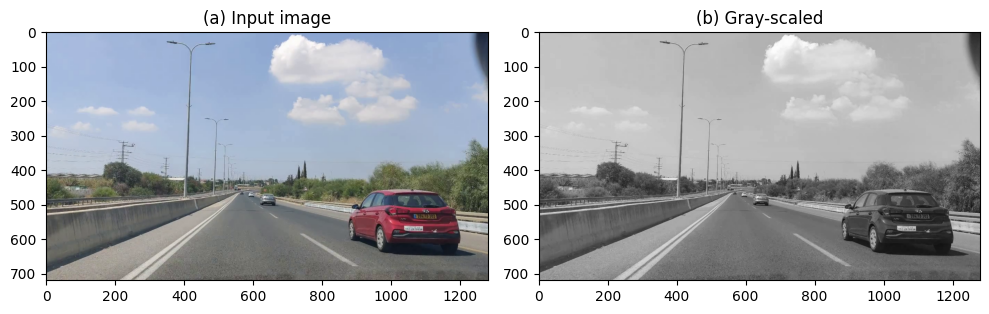

In [10]:
Utils.plot_images({'img': v1_f1, 'title': '(a) Input image'}, {'img': v1_f1_gray, 'title': '(b) Gray-scaled', 'cmap': 'gray'}, save_fig="images/doc/a1/daylight_video_gray_scale.png")

### 4.2. Image smoothing

- Average blur - takes the average of all the pixels under the kernel area and replaces the central element
- Gaussian blur
    - applies Gaussian kernel to the image, smoother blur compared to averaging
    - Intended to remove the noise that approximately follows the Gaussian distribution
    - can be used to remove the noise caused by the rain, snow and dirty roads
- Median blur
    - applies median blur to the image, by replaces each pixel's value with the median value of the neighboring pixels. 
    - effective for removing salt-and-pepper noise.

In [11]:
kernel_sizes = [3, 5, 7, 11]
daylight_blurred_images = {k: {} for k in ['averaging', 'gaussian', 'median']}
for b in daylight_blurred_images:
    func_obj = getattr(ImgProc, f'{b}_blur')
    for s in kernel_sizes:
        ks = s if b in ['median'] else (s, s)
        daylight_blurred_images[b][s] = {'img': func_obj(v1_f1_gray, ksize=ks), 'title': f'{b.capitalize()} blur (kernel {s}x{s})', 'cmap': 'gray'}

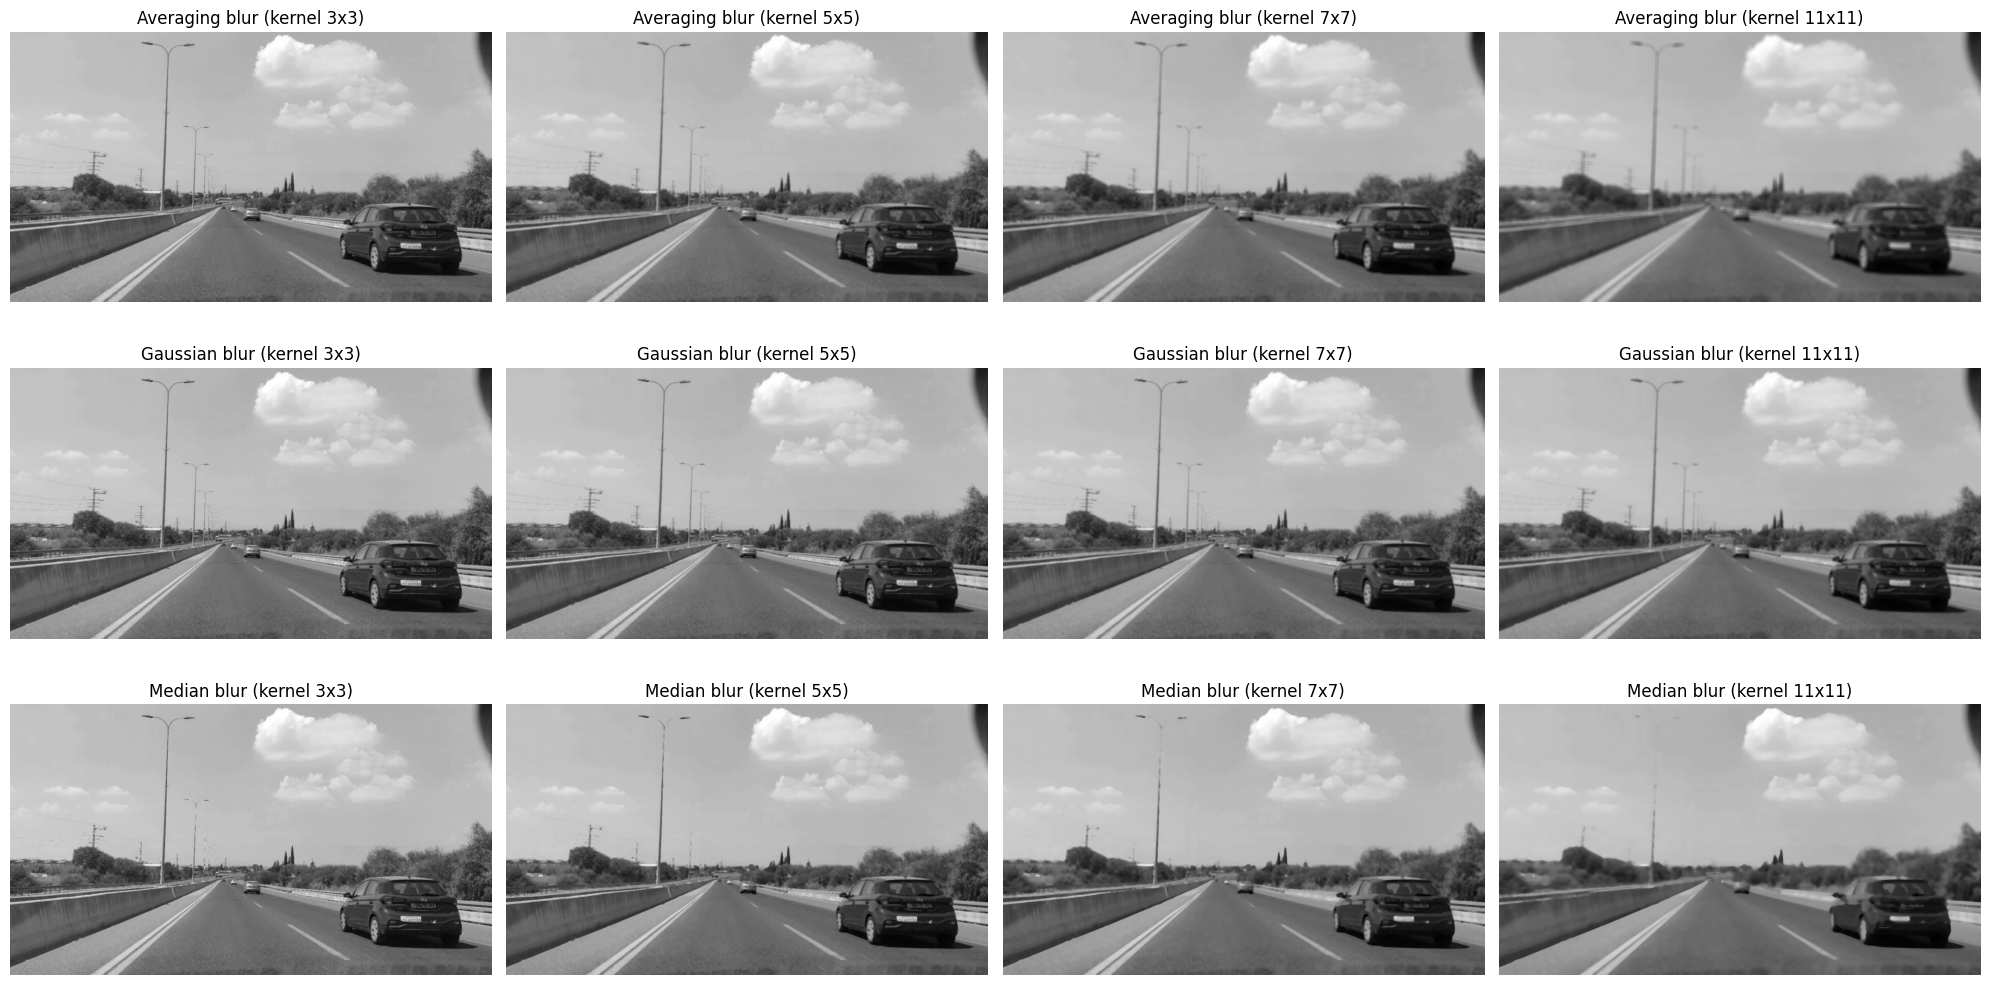

In [12]:
Utils.plot_images(*[el for v in daylight_blurred_images.values() for el in v.values()], width=5, height=3.5, axis='off', save_fig="images/doc/a1/daylight_video_smoothing_diff_kernels.png")

#### 4.3. Edge detection

In [13]:
img_blur_gaussian = daylight_blurred_images['gaussian'][11] # reference image after Gaussian blur
edge_detetect_images = {k: {} for k in ['sobel', 'canny', 'laplacian']}  # dictionary to store the results

##### Sobel (x and y directions)

In [14]:
sobel_params = [{'ksize': 1, 'threshold': 10}, {'ksize': 3, 'threshold': 45}, {'ksize': 3, 'threshold': 45}, {'ksize': 5, 'threshold': 700}, {'ksize': 7, 'threshold': 9000}]
for sp in sobel_params:
    key = tuple(sp.values())
    title = 'Sobel XY ({})'.format(', '.join([f'{k}: {v}' for k, v in sp.items()]))
    edge_detetect_images['sobel'][key] = {'img': ImgProc.sobel(img_blur_gaussian['img'], **sp), 'title': title, 'cmap': 'gray'}

##### Canny

In [15]:
canny_thresholds = [(10, 200), (40, 50), (75, 150), (30, 80)]
for th in canny_thresholds:
    edge_detetect_images['canny'][th] = {'img': ImgProc.canny(img_blur_gaussian['img'], threshold_low=th[0], threshold_high=th[1]), 'title': f'Canny (thresh low:{th[0]}, high:{th[1]})', 'cmap': 'gray'}

##### Laplacian

In [16]:
kernel_sizes = [1, 3, 5, 7]

for s in kernel_sizes:
     lap_edges_img = ImgProc.laplacian(img_blur_gaussian['img'], ksize=s)
     lap_edges_img = cv2.convertScaleAbs(lap_edges_img)
     edge_detetect_images['laplacian'][s] = {'img': lap_edges_img, 'title': f'Laplacian (ksize: {s})', 'cmap': 'gray'}

Display all edge detection results

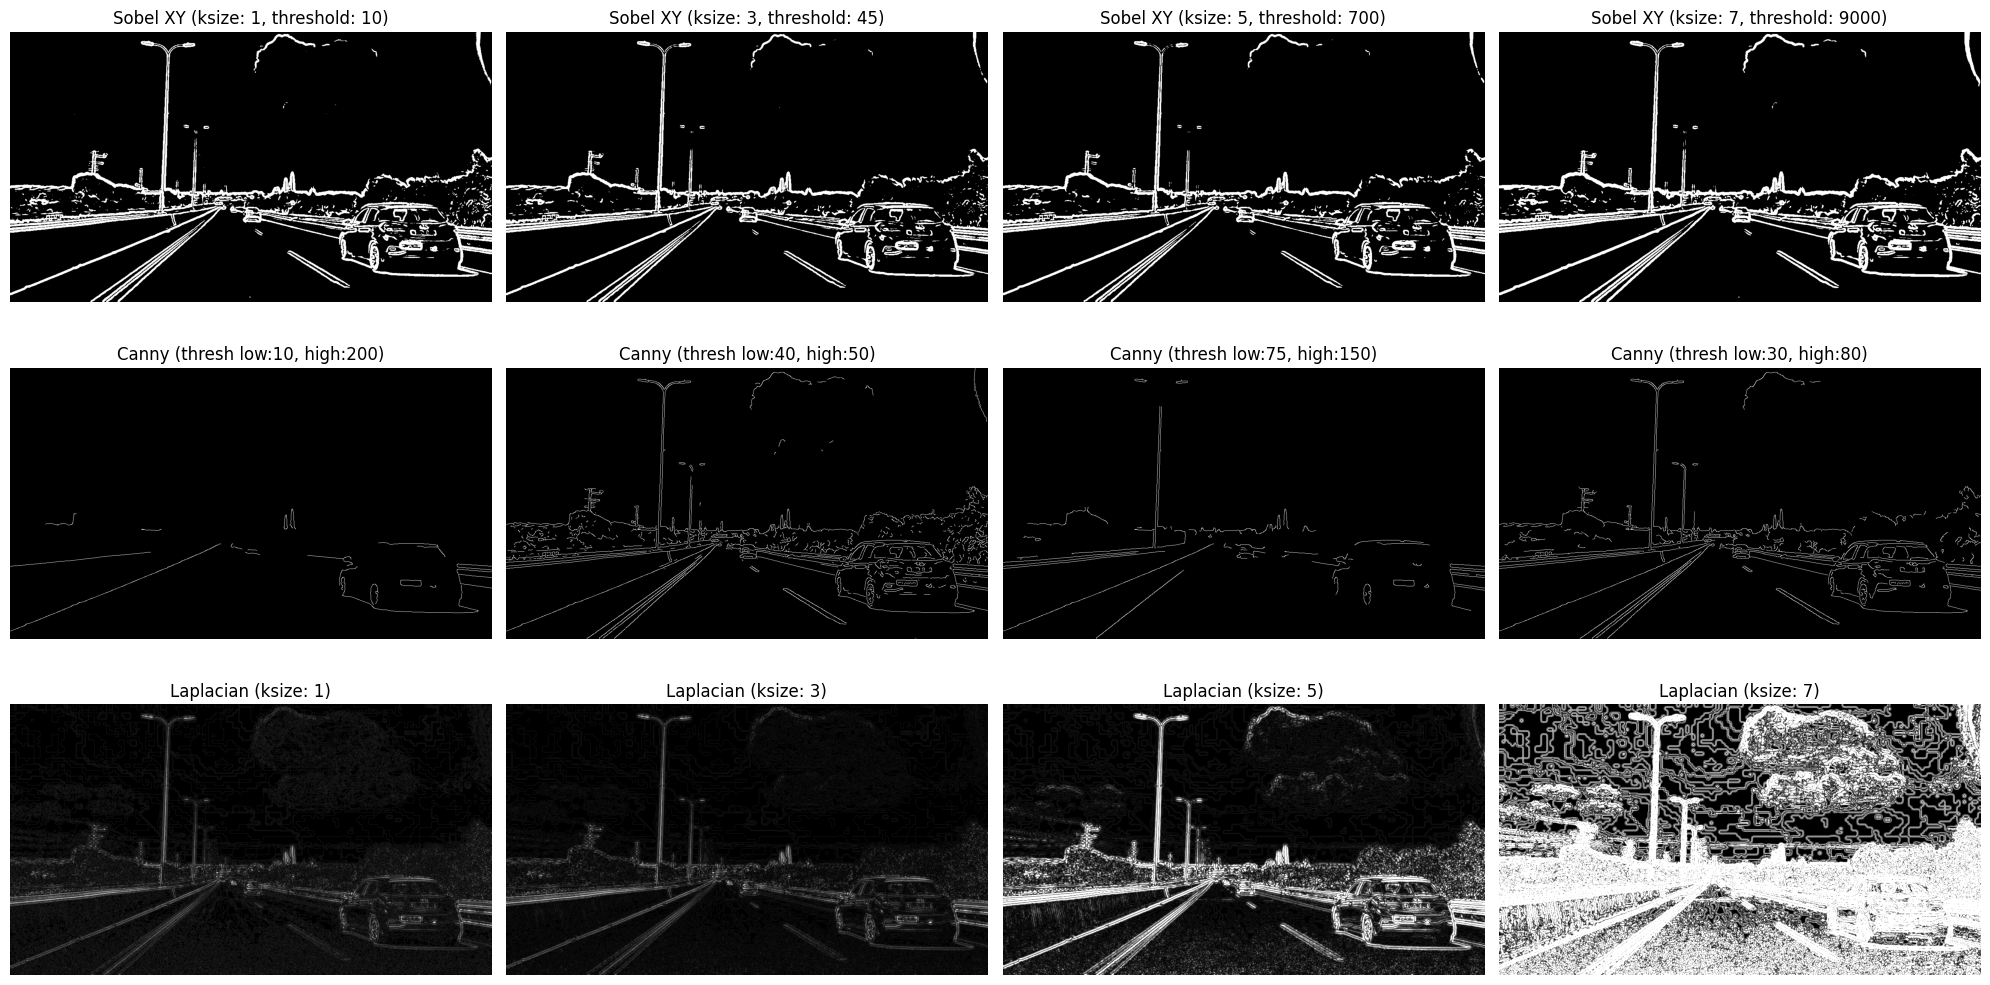

In [17]:
Utils.plot_images(*[el for v in edge_detetect_images.values() for el in v.values()], width=5, height=3.5, axis='off', save_fig="images/doc/a1/daylight_video_edge_detection_experiments.png")

##### Edge detection - best results
Best results achieved with Canny edge detection (see below) 

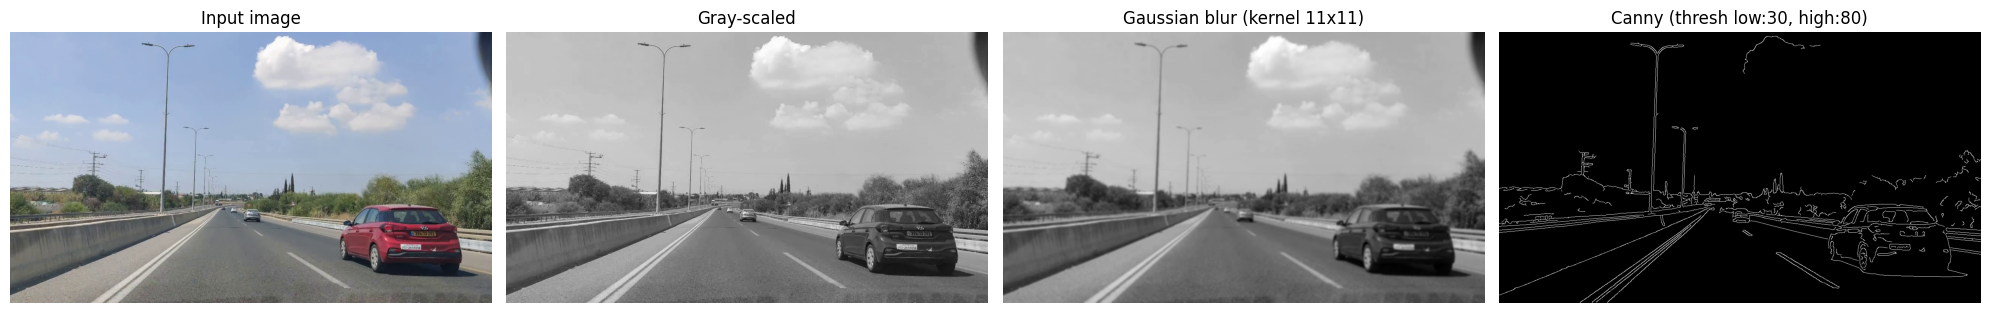

In [18]:
Utils.plot_images({'img': v1_f1, 'title': 'Input image'}, {'img': v1_f1_gray, 'title': 'Gray-scaled', 'cmap': 'gray'}, img_blur_gaussian, edge_detetect_images['canny'][(30, 80)], width=5, height=3.5, axis='off',  save_fig="images/doc/a1/daylight_video_canny_multi_step.png")

#### 4.4. ROI (Region of Interest) 
The polygonal ROI (region of interest) - part of the image we want to focus on. \
It's important to define the ROI, which can improve the computational time. \
Instead of processing the whole image we are concetrating only on specific part of the image where road lanes are likely to be.

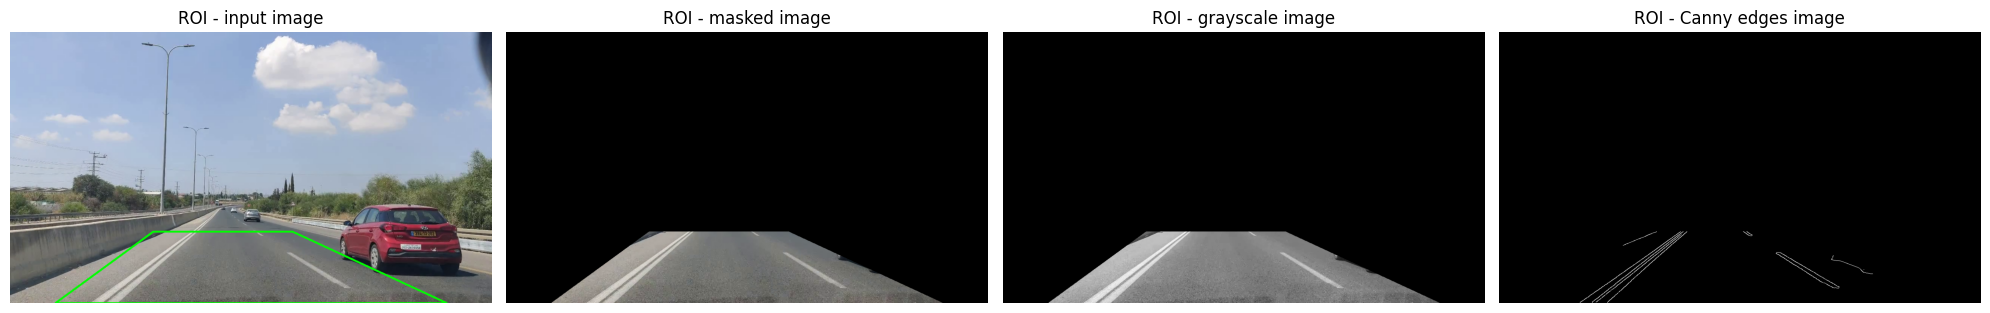

In [19]:
# manually define the trapezoidal ROI area for daylight video
height, width = v1_f1.shape[:2]
polygon = np.array([[
    (120, height),
    (380, 530),
    (750, 530),
    (width - 120, height),
]], np.int32)

v1_f1_edges = edge_detetect_images['canny'][(30, 80)]

v1_f1_roi_area = {'img': v1_f1.copy(), 'title': 'ROI - input image'} 
cv2.polylines(v1_f1_roi_area['img'], polygon, isClosed=True, color=(0, 255, 0), thickness=3)

v1_f1_masked = {'img': LaneTracker.region_of_interest(v1_f1, polygon), 'title': 'ROI - masked image'}
v1_f1_gray_masked = {'img': LaneTracker.region_of_interest(v1_f1_gray, polygon), 'title': 'ROI - grayscale image', 'cmap': 'gray'}
v1_f1_edges_masked = {'img': LaneTracker.region_of_interest(v1_f1_edges['img'], polygon), 'title': 'ROI - Canny edges image', 'cmap': 'gray'}

Utils.plot_images(v1_f1_roi_area, v1_f1_masked, v1_f1_gray_masked, v1_f1_edges_masked, width=5, height=3.5, axis='off', save_fig="images/doc/a1/daylight_video_roi.png")

#### 4.5. Probabilistic Hough Line Transform
Hough Transform, a well-established technique for mapping line features. \
After detection straight lines applied to the edge-detected image, we can analyze these lines, select the ones related to lane markings and distinguish between left and right line by observing the slope and intercept values.

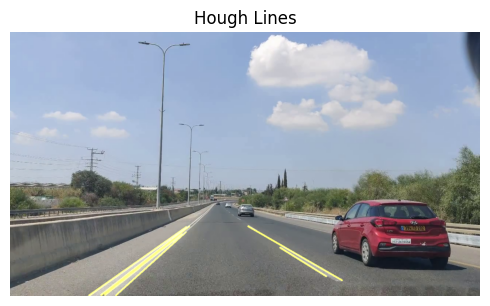

In [20]:
rho = 1             # distance resolution in pixels 
theta = np.pi/180   # angular resolution in radians 
threshold = 80      # minimum number of votes 
min_line_len = 40   # minimum number of pixels making up a line
max_line_gap = 110  # maximum gap in pixels between connectable line segments   

hl_color, line_thickness = (255, 255, 0), 4

# detect lines in the image within the ROI using Probabilistic Hough Line Transform
lines = ImgProc.hough_lines_prob(v1_f1_edges_masked['img'], rho, theta, threshold, min_line_len, max_line_gap)
# draw lines
hough_line_params = [{'coordinates': l[0], 'color': (255, 255, 0), 'thickness': 4} for l in lines]
v1_f1_hough_lines ={'img': LaneTracker.draw_lines(v1_f1, hough_line_params), 'title': 'Hough Lines'}

Utils.plot_images(v1_f1_hough_lines,  width=5, height=3.5, axis='off', save_fig="images/doc/a1/daylight_video_hough_lines.png")

### 4.6. Detect Right and Left Lane Lines

After lines were detected in the ROI, we can classify them into left/right lane lines by analyzing the slope.\
Slope calculation: $(y_2 - y_1) / (x_2 - x_1)$

**Lines classification**:
  - Left lane lines: typically have a negative slope (downwards from left to right)
  - Right lane lines: typically have a positive slope (upwards from left to right)

**Filter lines**:
  - Filter out lines that don't meet a certain slope threshold to remove noise. \
    For example - slope threshold 0.5:
      - left lines filtered by slope < -0.5
      - right lines filtered by slope > +0.5

**Detect representative lines**:
  - Process the remaining lines to get a single representative line for each lane
    - longest line - the longest among the detect lines on the left and right sides
    - average line - average left and right lines
    - least squares line - find the representative line start and end points using the least squares fitting

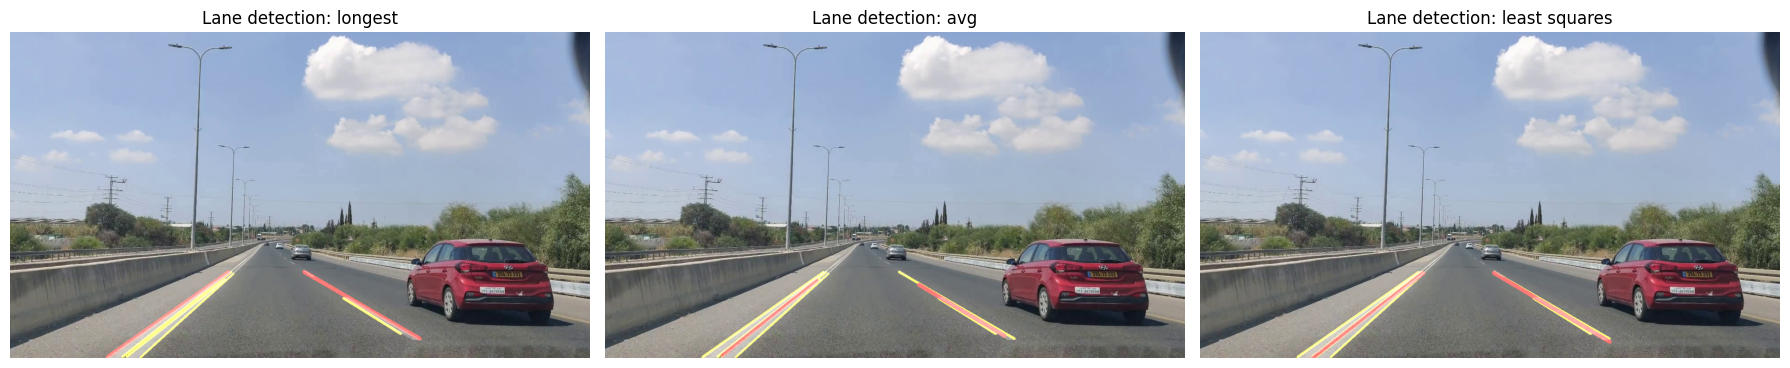

In [21]:
draw_lines_flag = {k: True if k in ['regular', 'representative'] else False for k in LaneTracker.default_draw_lines_flags}
dominant_lines = []
for m in ['longest', 'avg', 'least squares']:
    LaneTracker.init_params()
    vc_processed = vclip_1.fl_image(lambda img: LaneTracker.process_image(img, edge_detection='canny', polygon=polygon, process_lines=m, slope_threshold=0.5, threshold_low=30, threshold_high=80, draw_lines_flag=draw_lines_flag))
    dominant_lines.append({'img': VidProc.get_clip_frame(vc_processed, frame_indx), 'title': f'Lane detection: {m}'})

Utils.plot_images(*dominant_lines,  width=6, height=4, axis='off', save_fig="images/doc/a1/daylight_video_representative_lines.png")

### 4.7. Draw lines 

**Find intersection**:
  - Create reference horizontal lines in the top and bottom of the ROI area
  - Find the intersection of the filtered domninant left and right lines
  - Draw the lines on top of the image

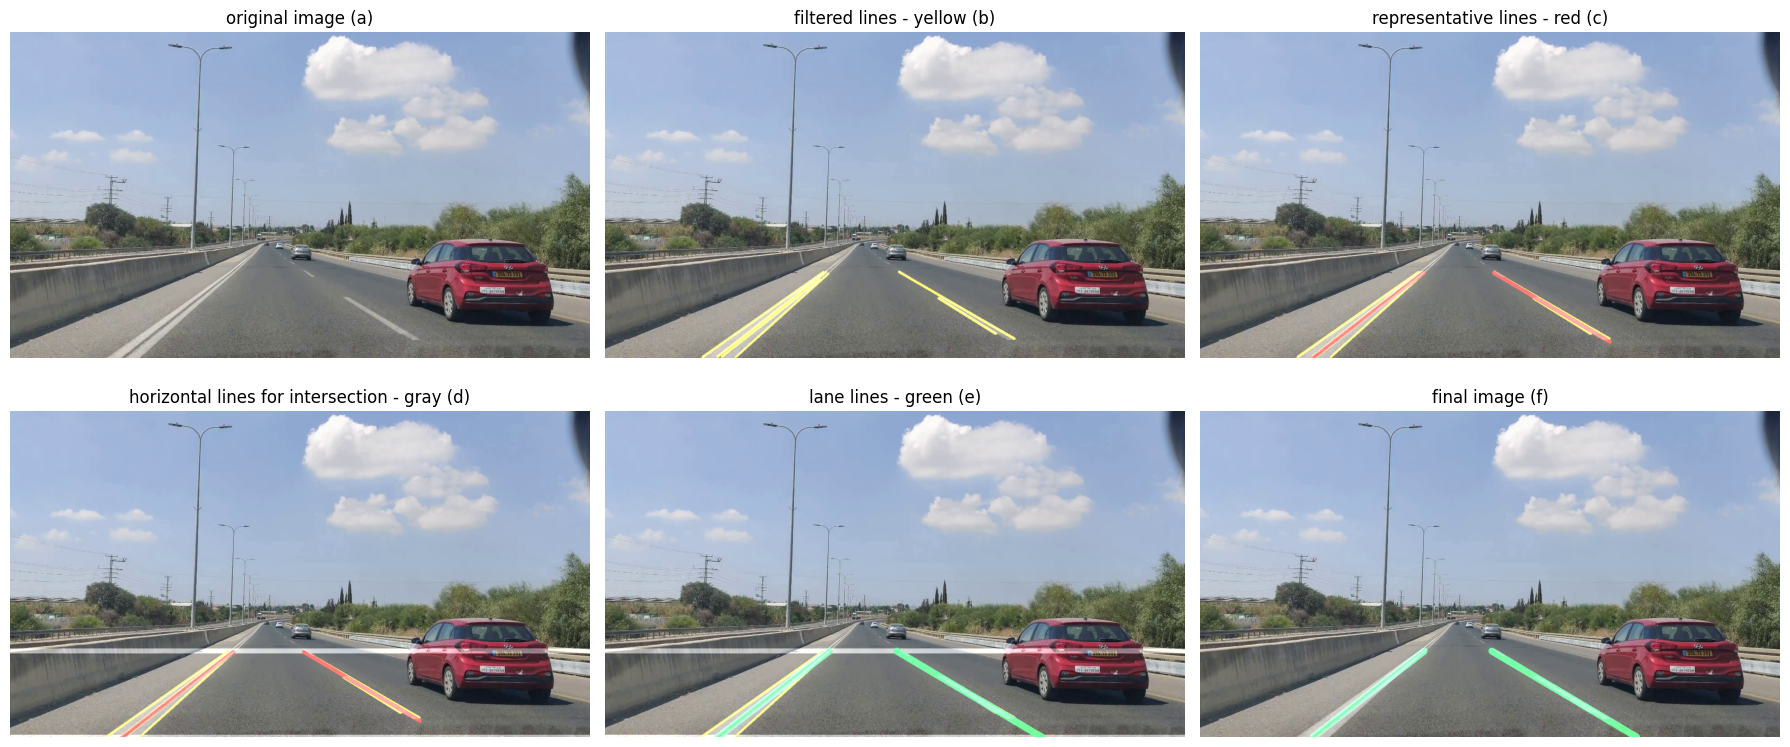

In [22]:
draw_lines_flag_coll = {'original image (a)': {k: False for k in LaneTracker.default_draw_lines_flags},
                        'filtered lines - yellow (b)': {k: True if k == 'regular' else False for k in LaneTracker.default_draw_lines_flags},
                        'representative lines - red (c)': {k: True if k in ['regular', 'representative']  else False for k in LaneTracker.default_draw_lines_flags},
                        'horizontal lines for intersection - gray (d)': {k: True if k != 'final' else False for k in LaneTracker.default_draw_lines_flags},
                        'lane lines - green (e)': {k: True for k in LaneTracker.default_draw_lines_flags},
                        'final image (f)': None}
img_coll = []
for k, dlf in draw_lines_flag_coll.items():
    LaneTracker.init_params()
    vc_processed = vclip_1.fl_image(lambda img: LaneTracker.process_image(img, edge_detection='canny', polygon=polygon, process_lines='least squares', slope_threshold=0.5, threshold_low=30, threshold_high=80, n_samples=1, draw_lines_flag=dlf))
    img_coll.append({'img': VidProc.get_clip_frame(vc_processed, frame_indx), 'title': f'{k}'})

Utils.plot_images(*img_coll, n_cols=3, width=6, height=4, axis='off', save_fig="images/doc/a1/daylight_video_draw_lines.png")

**Moving average smoothing**
  - We apply the moving average smoothing on N samples using the formula \
    $\text{moving average(x)} = (\text{current average}) - \frac{\text{(current average)}}{N} + \frac{x}{N}$ \
    where $x$ is the new sample of line coordinates and $N$ is number of samples over which the average is calculated
    - $\text{current average}/ N $ - subtracting the influence of the oldest sample
    - $\text{x}/ N$ - adding the influence of the new sample
    - higher N value means smoother average, less sensetive to short term changes
    - lower N value - more responsive average, more sensetive to recent changes 

Q: Why to use smoothing moving average in lane line detection? \
A: Benefits:
1. **Noise reduction** - Video frames can contain a lot of noise due to varying lighting conditions, shadows, and other environmental factors. A moving average helps to smooth out these fluctuations, making the detected lane lines more consistent
2. **Stability Over Time** - Lane lines can appear jittery or unstable from frame to frame due to minor variations in detection. By averaging the detected lane positions over several frames, the moving average provides a more stable and reliable representation of the lane lines
3. **Handling Occlusions** - Temporary occlusions (like passing vehicles or pedestrians) can disrupt lane detection. Smoothing helps to maintain the continuity of lane lines even when they are partially obscured
4. **Improved accuracy** - By reducing the impact of outliers and transient errors, the moving average can improve the overall accuracy of lane detection, ensuring that the detected lanes are more closely aligned with the actual road markings

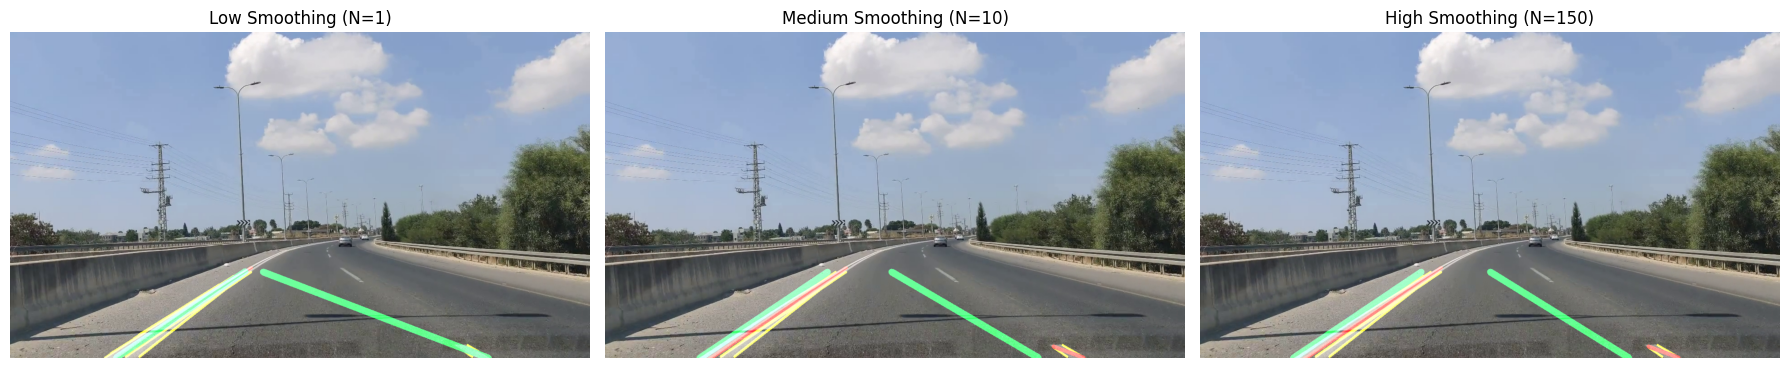

In [23]:
dlf = {k: True if k != 'reference' else False for k in LaneTracker.default_draw_lines_flags}
smoothing_params = {'Low': 1, 'Medium': 10, 'High': 150}
img_coll = []
vid_coll = {}
for i,(k, N) in enumerate(smoothing_params.items()):
    LaneTracker.init_params()
    vid_coll[k] = vclip_1.fl_image(lambda img: LaneTracker.process_image(img, edge_detection='canny', polygon=polygon, process_lines='least squares', slope_threshold=0.5, threshold_low=30, threshold_high=80, n_samples=N, draw_lines_flag=dlf))
    img_coll.append({'img': VidProc.get_clip_frame(vid_coll[k] , frame_indx=930), 'title': f'{k} Smoothing (N={N})'})
Utils.plot_images(*img_coll, n_cols=3, width=6, height=4, axis='off')

## 4. Process Video
- Apply the defined pipeline to the input video
- Save output video

### Daylight video

In [24]:
# read input video
vclip_day = VideoFileClip(input_video_day)

# process video including debug info
draw_all = {k: True for k in LaneTracker.default_draw_lines_flags}
LaneTracker.init_params()
vclip_day_processed_1 = vclip_day.fl_image(lambda img: LaneTracker.process_image(img, edge_detection='canny', polygon=polygon, process_lines='least squares', slope_threshold=0.5, threshold_low=30, threshold_high=62, hough_thresh=75, draw_lines_flag=draw_all))

# process video without debug info
LaneTracker.init_params()
vclip_day_processed_2 = vclip_day.fl_image(lambda img: LaneTracker.process_image(img, edge_detection='canny', polygon=polygon, process_lines='least squares', slope_threshold=0.5, threshold_low=30, threshold_high=62, hough_thresh=75))

In [25]:
out_file_names = {'daylight_w_debug': "videos/out/a1/daylight_video_1280x720_out_w_debug_info.mp4",
                  'daylight': "videos/out/a1/daylight_video_1280x720_out.mp4",
                  'night_w_debug': "videos/out/a1/night_video_1280x720_out_w_debug_info.mp4",
                  'night': "videos/out/a1/night_video_1280x720_out.mp4"}

Write to file processed video **with** debug info

In [26]:
# uncommnet the below line if you want to write the output video to file (VidProc.write_to_file = True)
# VidProc.write_to_file = True
VidProc.write_video(video_clip=vclip_day_processed_1, output_file=out_file_names['daylight_w_debug'])

Write to file processed video **without** debug info

In [27]:
VidProc.write_video(video_clip=vclip_day_processed_2, output_file=out_file_names['daylight'])

Display video

In [28]:
VidProc.display_video([out_file_names[k] for k in ['daylight', 'daylight_w_debug'] ], title=['Lane detection in daylight', 'Lane detection in daylight (with debug)'], method='html')

### Night video

In [29]:
# video file location
input_video_night = 'videos/in/night_video_1280x720.mp4'

# read input video
vclip_night = VideoFileClip(input_video_night)

# manually define the trapezoidal ROI area for daylight video
width, height = vclip_night.size
polygon = np.array([[
    (250, height),
    (380, 530),
    (750, 530),
    (width - 250, height),
]], np.int32)

# process video including debug info
LaneTracker.init_params()
vclip_night_processed_1 = vclip_night.fl_image(lambda img: LaneTracker.process_image(img, edge_detection='canny', polygon=polygon, process_lines='least squares', slope_threshold=0.5, threshold_low=30, threshold_high=62, hough_thresh=75, draw_lines_flag={k: True for k in LaneTracker.default_draw_lines_flags}))

# process video without debug info
LaneTracker.init_params()
vclip_night_processed_2 = vclip_night.fl_image(lambda img: LaneTracker.process_image(img, edge_detection='canny', polygon=polygon, process_lines='least squares', slope_threshold=0.5, threshold_low=30, threshold_high=62, hough_thresh=75))

Write to file processed video **with** debug info

In [ ]:
# # uncommnet the below line if you want to write the output video to file (VidProc.write_to_file = True)
# VidProc.write_to_file = True
VidProc.write_video(video_clip=vclip_night_processed_1, output_file=out_file_names['night_w_debug'])

Moviepy - Building video videos/out/a1/night_video_1280x720_out_w_debug_info.mp4.
Moviepy - Writing video videos/out/a1/night_video_1280x720_out_w_debug_info.mp4



Moviepy - Done !
Moviepy - video ready videos/out/a1/night_video_1280x720_out_w_debug_info.mp4


Write to file processed video **without** debug info

In [31]:
VidProc.write_video(video_clip=vclip_night_processed_2, output_file=out_file_names['night'])

Moviepy - Building video videos/out/a1/night_video_1280x720_out.mp4.
Moviepy - Writing video videos/out/a1/night_video_1280x720_out.mp4



Moviepy - Done !
Moviepy - video ready videos/out/a1/night_video_1280x720_out.mp4


Display video

In [32]:
VidProc.display_video([out_file_names[k] for k in ['night', 'night_w_debug']], title=['Lane detection at night', 'Lane detection at night (with debug)'], method='html')

## 5. Summary

We have recorded videos for experiments during the daylight and at night.
As part of the work we examined different methods for image smoothing, edge detection and lane line filtering.
In most of the video frames we were able to detect the straight lines successfully using calibrated Canny edge detection and Probabilistic Hough Line Transform.

**Advantages**:
- Simplicity - relatively simple to implement and understand
- Efficency - very effective in computation, provides real time video processing
- Noise robustnsess - Canny edge detection able to detect the edges even in non-optimal noisy images
- Shows good results in clear road condition where marking are clear and well defined

**Disadvantages**:
- ROI manually defined - in case the road will go up and down, the manully defined region of interest will be not effective
- Lmited to straight lines - Hough Trasform designed to detect straight lines, and less suitable for cuved road lanes.
- Sensetivity to lightning condition - lightning condition like shadow or faded markings can affect the accuracy of lane detection. \
  For example - when the road is under construction the lane markings have orange faded color (like in our daylight video), in this case additional processing is required, \
  it can be parameter tunning in Canny edge detection or thresholding, dilation to enhance the white color.

This approach serves as good baseline but requires improvements. 
In 2nd approach we'll try to answer/handle some of the disadvantages, such as polynomial fitting for curved lines and \
threhsholding for white color enhancement, in order to enhance the accuracy of the lane lines detection.